## 1. Data Structure

In [1]:
import torch
import os
from pathlib import Path
import pathlib
import random
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
# define a function to display all the contents in a directory
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        if "NORMAL" in dirpath or "PNEUMONIA" in dirpath:
            print(f"There are {len(filenames)} images in '{dirpath}'.")

In [2]:
path = "../../Datasets/X-Ray"
walk_through_dir(path)

There are 234 images in '../../Datasets/X-Ray\test\NORMAL'.
There are 390 images in '../../Datasets/X-Ray\test\PNEUMONIA'.
There are 1349 images in '../../Datasets/X-Ray\train\NORMAL'.
There are 3883 images in '../../Datasets/X-Ray\train\PNEUMONIA'.
There are 0 images in '../../Datasets/X-Ray\val\NORMAL'.
There are 0 images in '../../Datasets/X-Ray\val\PNEUMONIA'.


 **Display some random image**

In [3]:
path = "../../Datasets/X-Ray"
image_path = Path(path)
image_path

WindowsPath('../../Datasets/X-Ray')

In [4]:
p = list(image_path.glob("*/*/*.jpeg"))
p[:3]

[WindowsPath('../../Datasets/X-Ray/test/NORMAL/IM-0001-0001.jpeg'),
 WindowsPath('../../Datasets/X-Ray/test/NORMAL/IM-0003-0001.jpeg'),
 WindowsPath('../../Datasets/X-Ray/test/NORMAL/IM-0005-0001.jpeg')]

In [5]:
print(p[0].parent)
print(p[0].parent.stem)
print(p[0].parent.name)

..\..\Datasets\X-Ray\test\NORMAL
NORMAL
NORMAL


In [6]:
type(image_path)

pathlib.WindowsPath

In [7]:
import random
from PIL import Image
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

Image.MAX_IMAGE_PIXELS = None

# create a function to visualize random image from our dataset
def show_sample_image(image_path: pathlib.WindowsPath,image_suffix: str):
    # get path for all images
    image_path_list = list(image_path.glob("train/*/*."+image_suffix))
    
    # select a random image
    random_img = random.choice(image_path_list)
    print(f"Random Image Selected: {random_img}")
    
    # display the class the image belongs to
    random_img_class = random_img.parent.stem
    print(f"Random Image Class: {random_img_class}")
    
    # show the image
    img = Image.open(random_img)
    
    # display meta data
    print(f"Image Dimension: {img.height} x {img.width}")
    
    plt.imshow(img,cmap="gray")
    
    return img


Random Image Selected: ..\..\Datasets\X-Ray\train\NORMAL\NORMAL2-IM-1220-0001.jpeg
Random Image Class: NORMAL
Image Dimension: 1510 x 1596


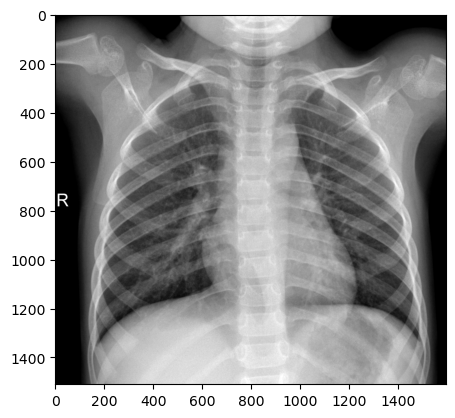

In [8]:

img = show_sample_image(image_path,"jpeg")

**Find the distribution of dimensions of the images**

In [9]:
from tqdm.auto import tqdm
# function to retrieve a list of dimensions of the images
def retrieve_dimension(image_path:pathlib.WindowsPath,image_suffix:str):
    # all image path
    all_path = list(image_path.glob("*/*/*."+image_suffix))
    
    # iterate through the images and record dimensions
    heights = []
    widths = []
    for i in tqdm(range(len(all_path))):
        img = Image.open(all_path[i])
        heights.append(img.height)
        widths.append(img.width)
    
    return heights, widths

In [10]:
image_path = Path(path)
heights, widths = retrieve_dimension(image_path,"jpeg")
len(heights),len(widths)

  0%|          | 0/5856 [00:00<?, ?it/s]

(5856, 5856)

<Figure size 800x800 with 0 Axes>

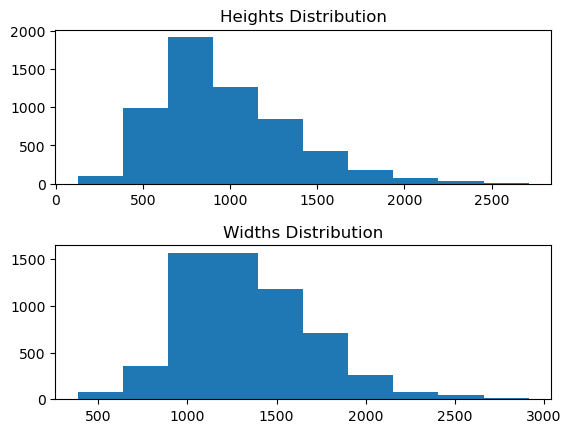

In [11]:
# plot the distributions
plt.figure(figsize=(8,8))
fig, axs = plt.subplots(nrows=2,ncols=1)
axs[0].hist(heights)
axs[0].set_title("Heights Distribution")
axs[1].hist(widths)
axs[1].set_title("Widths Distribution")
plt.subplots_adjust(hspace=0.4)
plt.show()

In [14]:
# convert data into pandas dataframe and look at summary statistics
import pandas as pd
df = pd.DataFrame(data={"height":heights,"width":widths})
df

,height,width
0,1317,1857
1,1509,2111
2,1837,2031
3,1326,1663
4,1818,2053
...,...,...
5851,882,1414
5852,696,1256
5853,856,1152
5854,728,1248


In [15]:
df.describe()

,height,width
count,5856.000000,5856.000000
mean,970.689037,1327.880806
std,383.392117,363.500922
min,127.000000,384.000000
25%,688.000000,1056.000000
50%,888.000000,1281.000000
75%,1187.000000,1560.000000
max,2713.000000,2916.000000


## 2. Data Preparation

**transformation**

In [2]:
from torchvision import transforms

input_size = (512,512)

# plot transformed data
transformation = transforms.Compose([
    transforms.Resize(size = input_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(),
    transforms.ToTensor()
])

test_transformation = transforms.Compose([
    transforms.Resize(size = input_size),
    transforms.Grayscale(),
    transforms.ToTensor()
])

def plot_transformed_images(image_paths:list, transformation, n=3):
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, axs = plt.subplots(nrows=1,ncols=2)
            # original image
            axs[0].imshow(f, cmap="gray")
            axs[0].set_title(f"Original Size: \n {f.height}x{f.width}")
            axs[0].axis(False)
            # transformed image
            transformed_image = transformation(f).permute(1,2,0)
            axs[1].imshow(transformed_image, cmap="gray")
            axs[1].set_title(f"Transformed Size: \n {transformed_image.shape}")
            axs[1].axis(False)

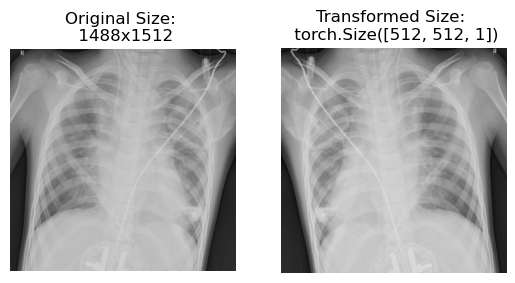

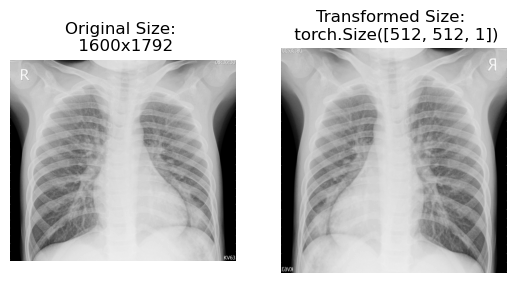

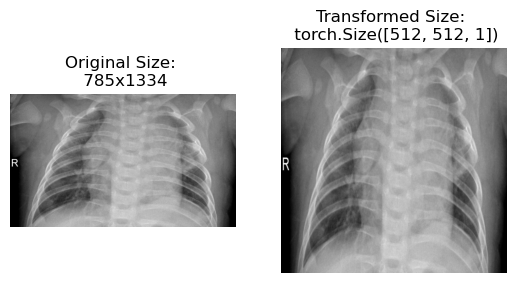

In [19]:
path = "../../Datasets/X-Ray"
image_path = Path(path)
image_path
image_path_list = list(image_path.glob("*/*/*.jpeg"))
plot_transformed_images(image_path_list, transformation, n=3)

**torch.dataset**

In [3]:
import torchvision
import numpy as np

path = "../../Datasets/X-Ray"

# use ImageFolder to create datasets
train_dir=path+"/train"
test_dir = path+"/test"

train_dataset = torchvision.datasets.ImageFolder(root=train_dir,transform=transformation)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir,transform=test_transformation)



len(train_dataset), len(test_dataset)

(5232, 624)

**inspect the images**


In [20]:
class_names = train_dataset.classes
class_names

['NORMAL', 'PNEUMONIA']

In [21]:
img = train_dataset[0][0]
img.shape

torch.Size([1, 512, 512])

In [22]:
img[0]

tensor([[0.3725, 0.3725, 0.3725,  ..., 0.0784, 0.0863, 0.0902],
        [0.3725, 0.3725, 0.3686,  ..., 0.0784, 0.0902, 0.0902],
        [0.3725, 0.3725, 0.3686,  ..., 0.0863, 0.0863, 0.0863],
        ...,
        [0.3647, 0.3608, 0.3608,  ..., 0.1529, 0.1490, 0.1529],
        [0.4196, 0.4118, 0.4157,  ..., 0.1725, 0.1686, 0.1725],
        [0.4745, 0.4706, 0.4706,  ..., 0.1961, 0.2000, 0.1961]])

Text(0.5, 1.0, 'NORMAL\nSize: torch.Size([1, 512, 512])')

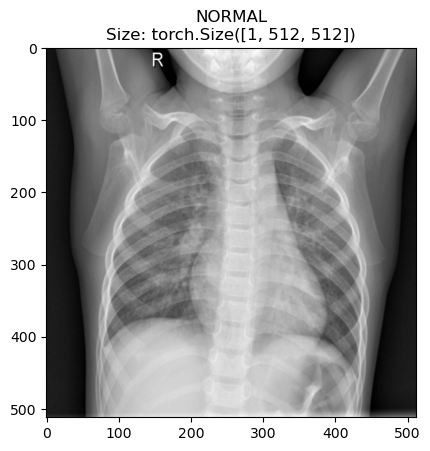

In [23]:
img = train_dataset[0][0]
label_index = train_dataset[0][1]
label=class_names[label_index]
plt.imshow(img.permute(1,2,0),cmap="gray")
plt.title(f"{label}\nSize: {img.shape}")

In [24]:
# check number type
print(f"The Datatype of image tensors: {img.dtype}")
print(f"The Datatype of label: {type(label_index)}")

The Datatype of image tensors: torch.float32
The Datatype of label: <class 'int'>


**torch.dataloader**

In [4]:
import numpy as np
np.random.seed(100)
# construct validation dataset from training dataset
val_data_portion = 0.15
training_data_index = np.arange(len(train_dataset))
np.random.shuffle(training_data_index)
val_split = np.round(val_data_portion*len(training_data_index),0).astype(int)
val_idx = training_data_index[:val_split]
train_idx = training_data_index[val_split:]
print(f"first 10 indicies for train_idx: {train_idx[:10]}\n")

val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)

print(f"size of training data: {len(train_idx)}\nsize of validation data: {len(val_idx)}")

first 10 indicies for train_idx: [1480 3003 2004 2909 2480  598 3228 5157 1877  719]

size of training data: 4447
size of validation data: 785


In [5]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE =32
workers = os.cpu_count()
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,drop_last=True,
                              sampler=train_sampler)
val_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,drop_last=True,
                            sampler = val_sampler)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,drop_last=False)

print(f"There are {len(train_dataloader)} batches of training data, {len(val_dataloader)} batches of validation data"\
      + f" and {len(test_dataloader)} batches of test data")


There are 138 batches of training data, 24 batches of validation data and 20 batches of test data


In [10]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 1, 512, 1024])
Label shape: torch.Size([8])


## 3. Model Definition
**base_line model**  
  
  
3 blocks of cov layers
- 1. 256 feature maps (5x5 kernel, stride 2, padding 1) + BatchNorm + RELU + Max pool
- 2. 2x(512 feature maps (5x5 kernel, stride 2, padding 1) + BatchNorm + RELU) + Max pool
- 3. 2x(1024 feature maps (3x3 kernel, stride 1, padding 1) + BatchNorm + RELU) + Max pool  
  
dense layer
- flatten layer 
- linear layer + RELU

with dropout layer after each block with probability of 10* of zeroing out an element - p = 0.1


**ideas of experimentation***
- 1.change max_pool layer stride to not equal to the window size
- 2.use none_square windows


In [6]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
os.listdir("../helper_functions")

['.git',
 'conv_network.py',
 'dependencies.ipynb',
 'loss_functions.py',
 'README.md',
 'train_test_loop.py',
 'update_utilities.py']

In [29]:
from update_utilities import update_utilities_class
update_file = update_utilities_class(file_name="conv_network.py",current_path=os.getcwd())
update_file.run()

File copied, now the file is available to import from the destinated path


In [7]:
from conv_network import three_layer_conv_network
model0 = three_layer_conv_network(conv_dimensions = [256,512,1024],
                    kernel_sizes = [(5,5),(3,3),(3,3)],
                    strides = [2,2,1],
                    pool_sizes = [(2,2),(2,2),(2,2)],
                    pool_strides=[(2,2),(2,2),(2,2)],
                    input_dimension=[1,1,512,512],
                    output_logit=1,
                    dropout_prob=[0.2,0.2,0.2,0.4],
                    paddings = [1,1,1],
                    dense_neuron=2048).to(device)

This is a sample forward pass
--------------------------------

input size: torch.Size([1, 1, 512, 512])

after the first convolutional layer, output size: torch.Size([1, 256, 127, 127])

after the second convolutional layer, output size: torch.Size([1, 512, 16, 16])

after the third convolutional layer, output size: torch.Size([1, 1024, 8, 8])

after the flatten layer, output size: torch.Size([1, 65536])

Input for dense layer: torch.Size([1, 65536])

after the dense layers, output size: torch.Size([1, 1]), ready for loss calculation with logit transformation



In [8]:
# check if model is in gpu
next(model0.parameters()).device

device(type='cuda', index=0)

## 4. Pre-Trained models

**ResNet**

In [14]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
import torchvision.models as models
resnet = models.resnext101_64x4d(weights=None)
resnet.load_state_dict(torch.load("../../Pretrained_Weights/resnext101_64x4d-173b62eb.pth"))

<All keys matched successfully>

In [16]:
#resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Sequential(
    nn.Linear(2048,1,True)
)
#resnet.conv1 = nn.Conv2d(1,64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [58]:
next(resnet.parameters()).device

device(type='cuda', index=0)

## 5. Train and Test loop

In [35]:
from update_utilities import update_utilities_class
update_file = update_utilities_class(file_name="train_test_loop.py",current_path=os.getcwd())
update_file.run()

File copied, now the file is available to import from the destinated path


In [9]:
from train_test_loop import train_test_loop_class
model = model0
model_name = "base_model_lower_lr"
epoch = 3
print_every = 30
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-6)
loop_class = train_test_loop_class(model = model,
                                   train_loader = train_dataloader,
                                   val_loader = val_dataloader,
                                   test_loader = test_dataloader,
                                   epochs = epoch,
                                   device = device,
                                   model_name = model_name,
                                   optimizer = optimizer,
                                   calculate_accuracy=True,
                                   print_every_n_batch = print_every,
                                   problem_type = "Binary Classification",
                                   overwrite_message=True,
                                   update_loss_fn=False)



All initialized, ready to go!


In [10]:
len(train_dataloader),len(val_dataloader)

(138, 24)

In [11]:
loop_class.train()

Basic Specs
----------------------------------------------------
Input Size: torch.Size([32, 1, 512, 512])


Model Specs: 

three_layer_conv_network(
  (conv_1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout2d(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=(2,

  0%|          | 0/414 [00:00<?, ?it/s]

Training Begin
----------------------------------------------------
There are 3 epochs, and for each epoch, there are 138 batches of training data
Total Training Steps: 414
Total Displaying Information: 14
Optimizer name - AdamW learning rate: 2e-06
lowest_val_loss started with 1000000000



Message: 1 - Progress Summary - 30 batches
--------------------------------
Epoch: 1 / 3 || Batch: 30 / 414 || Print Cycle: 1 / 14
Average per-Batch Training Loss: 0.4691 || Average per-Batch Validation Loss: 0.6411
Average per-Batch Training Accuracy: 76.46% || Average per-Batch Validation Accuracy: 72.27%
This printing cycle took 0.5 minutes



Message: 2 - Progress Summary - 30 batches
--------------------------------
Epoch: 1 / 3 || Batch: 60 / 414 || Print Cycle: 2 / 14
Average per-Batch Training Loss: 0.3239 || Average per-Batch Validation Loss: 0.7331
Average per-Batch Training Accuracy: 86.56% || Average per-Batch Validation Accuracy: 72.53%

Model Improvement
------------------------------

In [12]:
test_loss, test_acc = loop_class.test(mode="test")

Average per-Batch Test Loss: 0.9914
Average per-Batch Test Accuracy: 65.31%
